<a href="https://colab.research.google.com/github/jansoe/introNLP/blob/main/TextClassification_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few Shot Text Classification RAFT: Bag of Words Baseline

---



### Benötigte Bibliotheken installieren/laden

In [ ]:
!pip install datasets --q

In [ ]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import numpy as np
import pandas as pd
import datasets
import sklearn.feature_extraction
from tensorflow import keras

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Daten laden

In [ ]:
# laden und formatieren
training_data = datasets.load_dataset('ought/raft', name='twitter_complaints')
train_data = training_data['train'].to_pandas()
train_data.Label = 2 - train_data.Label #konvertieren von Labels 2,1 zu 0,1

In [ ]:
train_data

,Tweet text,ID,Label
0,@HMRCcustomers No this is my first job,0,0
1,@KristaMariePark Thank you for your interest! ...,1,0
2,If I can't get my 3rd pair of @beatsbydre powe...,2,1
3,@EE On Rosneath Arial having good upload and d...,3,1
4,"Couples wallpaper, so cute. :) #BrothersAtHome",4,0
5,"@mckelldogs This might just be me, but-- eyedr...",5,0
6,@Yelp can we get the exact calculations for a ...,6,0
7,@nationalgridus I have no water and the bill i...,7,1
8,Never shopping at @MACcosmetics again. Every t...,8,1
9,@JenniferTilly Merry Christmas to as well. You...,9,0


## Daten kodieren

Vokabular erstellen und Wörter pro Tweet zählen

In [ ]:
bag_of_words = sklearn.feature_extraction.text.CountVectorizer()
word_counts_train = bag_of_words.fit_transform(train_data["Tweet text"].values)

#### Visualisierung der Datenkodierung

In [ ]:
fig = px.imshow(word_counts_train.todense(), labels={'x': 'word_id', 'y': 'sample_id', 'color': 'count'}, aspect='auto')

fig.update(
    data=[{
        'customdata': np.vstack([list(bag_of_words.get_feature_names_out())]*word_counts_train.shape[0]),
        'hovertemplate': 'Sample #: %{x}<br>Word: %{customdata}<br>Count: %{z}<extra></extra>'
    }]
)

#### Visualisierung der Worthäufigkeit pro Klasse

In [ ]:
word_counts_train_pos = bag_of_words.transform(train_data.loc[train_data.Label == 0, "Tweet text"])
word_counts_train_neg = bag_of_words.transform(train_data.loc[train_data.Label == 1, "Tweet text"])

px.bar(
    np.hstack([
        np.array((word_counts_train_pos>0).sum(0)).T,
        np.array((word_counts_train_neg>0).sum(0)).T
    ]),
    text = bag_of_words.get_feature_names_out(),
    labels={'color': 'complaint'}
)

## Modell erstellen

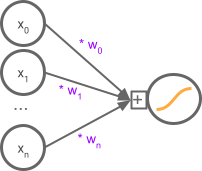

In [ ]:
model = keras.Sequential(
    [keras.layers.Dense(
        # input units
        input_dim=len(bag_of_words.vocabulary_),
        # output units 
        units = 1,                               
        activation='sigmoid',
    )]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 440       
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


#### Fehler und Optimierung hinzufügen

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
)

#### Modell trainieren

In [ ]:
model.fit(
    x = word_counts_train.todense(), 
    y = train_data.Label,
    batch_size = 5,
    epochs = 1000, 
    verbose = 0    
)

### Vorhersage der Trainingsdaten

In [ ]:
p = model.predict(word_counts_train.todense()).squeeze()

Anteil der korrekt klassifizierten Tweets

In [ ]:
accuracy = ((p>0.5) == train_data.Label).mean()
accuracy

1.0

Visualisierung der Vorhersagen

In [ ]:
px.bar(
    y=p-0.5, 
    color=train_data.Label, 
    template='plotly_dark', 
    text = train_data["Tweet text"],
    title = f'Accuracy {accuracy}'  
)


## Evaluieren auf Testdaten

In [ ]:
fulldata = pd.read_csv(
    'https://raw.githubusercontent.com/danielpreotiuc/complaints-social-media/master/complaints-data.csv', 
    names=['id', 'Tweet text', 'Label', 'category']
)

test_data = fulldata[~fulldata['Tweet text'].isin(training_data['train']['Tweet text'])]
test_data.shape

(3399, 4)

Daten kodieren

In [ ]:
word_count_test = bag_of_words.transform(test_data['Tweet text'])

Vorhersage

In [ ]:
p_test = model.predict(word_count_test.todense()).squeeze()

Visualisierung

In [ ]:
accuracy = ((p_test >0.5) == test_data.Label).mean()
px.bar(
    y= p_test-0.5, 
    color=test_data.Label, 
    template='plotly_dark', 
    text = test_data["Tweet text"],
    title = f'Accuracy {accuracy:.3f}'  
)

In [ ]:
bonus = False
if bonus:
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_predictions(test_data.Label, p_test > 0.5)